In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, multivariate_normal
from anesthetic.plot import kde_plot_1d, kde_contour_plot_2d

In [2]:
mu0 = np.array([1, 1])
mu1 = np.array([5, 5])
Sigma0 = np.array([[1, 0], [0, 1]])
Sigma1 = np.array([[1, 0], [0, 1]])

X0 = np.random.multivariate_normal(mu0, Sigma0, size=(10000))
X1 = np.random.multivariate_normal(mu1, Sigma1, size=(10000))

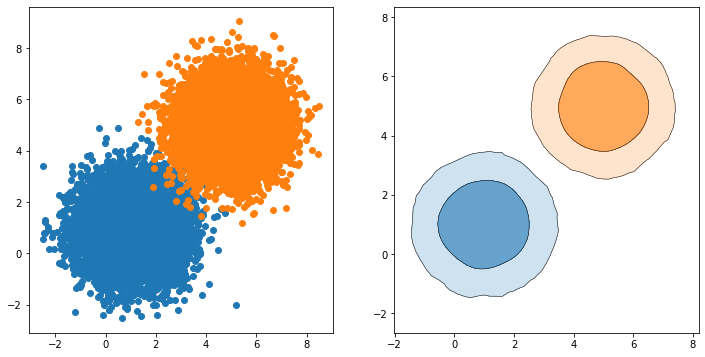

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(X0[:, 0], X0[:, 1])
axs[0].scatter(X1[:, 0], X1[:, 1])

kde_contour_plot_2d(axs[1], X0[:, 0], X0[:, 1])
kde_contour_plot_2d(axs[1], X1[:, 0], X1[:, 1])

plt.show()

## 1D Gaussian tension coordinate *t*
#### This is the analytical approach

t = \mu \Sigma^{-1} \theta

\mu = \mu_A - \mu_B

\Sigma = \Sigma_A + \Sigma_B

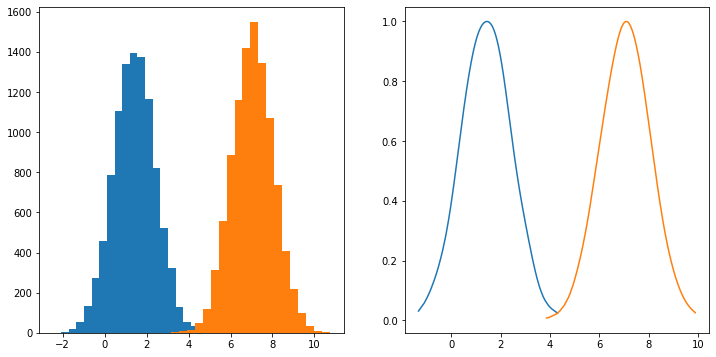

In [4]:
def dot_n(n, X):
    if n.shape[0] != X.shape[1]:
        raise ValueError("shape of n and X do not match")
    else:
        return np.matmul(np.transpose(n), np.transpose(X))

direc_n = np.matmul(np.transpose(mu0 - mu1), np.linalg.inv(Sigma0 + Sigma1))
direc_n = -direc_n / np.linalg.norm(direc_n)

X0_1d = dot_n(direc_n, X0)
X1_1d = dot_n(direc_n, X1)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].hist(X0_1d, bins=20)
axs[0].hist(X1_1d, bins=20)
kde_plot_1d(axs[1], X0_1d)
kde_plot_1d(axs[1], X1_1d)

## General tension coordinate t

Want to optimise the tension coordinate against a tension quantification method (either Bayes factor R or Suspiciousness statistic S)

### Bayes Factor R

We use the binning method as defined in the draft document written by Will and Liam

In [5]:
def get_limits(points):
    min_max = []
    for row in np.transpose(points):
        min_val = min(row)
        max_val = max(row)
        padding = (max_val - min_val) / 10
        min_max.append([min_val - padding, max_val + padding])
    
    return min_max

def bin_1d_kde(kde, limits, N=100):
    bin_width = (limits[1] - limits[0]) / N
    bins = [(limits[0] + i * bin_width, limits[0] + (i+1) * bin_width) for i in range(N)]
    bin_mids = [bin[0] + bin_width / 2 for bin in bins]
    weights = [kde.integrate_box(bin[0], bin[1]) for bin in bins]

    return bin_mids, weights    

def uniform_prior_samples(limits, size=1000):
    prior_samples = []
    for limit in limits:
        prior_samples.append(np.random.uniform(limit[0], limit[1], size=size))
    return np.transpose(np.array(prior_samples))

In [6]:
all_samples = np.concatenate((X0, X1), axis=0)
prior_limits = get_limits(all_samples)
X_prior = uniform_prior_samples(prior_limits, size=10000)

def marginalised_bayes_factor(n, XA, XB, X_prior):
    XA_1d = dot_n(n, XA)
    XB_1d = dot_n(n, XB)
    X_prior_1d = dot_n(n, X_prior)

    kdeA_1d = gaussian_kde(XA_1d)
    kdeB_1d = gaussian_kde(XB_1d)
    kde_prior_1d = gaussian_kde(X_prior_1d)

    kdeA_limits = get_limits(np.reshape(XA_1d, (-1, 1)))
    kdeB_limits = get_limits(np.reshape(XB_1d, (-1, 1)))
    kde_prior_limits = get_limits(np.reshape(X_prior_1d, (-1, 1)))

    binsA, weightsA = bin_1d_kde(kdeA_1d, kdeA_limits[0])
    binsB, weightsB = bin_1d_kde(kdeB_1d, kdeB_limits[0])
    bins_prior, weights_prior = bin_1d_kde(kde_prior_1d, kde_prior_limits[0])

    R = 0
    N_bins = 50 
    low_lim = kde_prior_limits[0][0]
    high_lim = kde_prior_limits[0][1]
    bin_width = (high_lim - low_lim) / N_bins
    large_bins = [(low_lim + i * bin_width, low_lim + (i + 1) * bin_width) for i in range(N_bins)]

    def weights_within_bin(idx, bins, weights, lower_lim, upper_lim):
        sum_A = 0
        for i in range(idx, len(bins)):
            if bins[i] > lower_lim and bins[i] < upper_lim:
                sum_A += weights[i]
                idx += 1
            else:
                break

        return idx, sum_A

    idxA = 0
    idxB = 0
    idx_prior = 0
    for large_bin in large_bins:
        idxA, sum_A = weights_within_bin(idxA, binsA, weightsA, large_bin[0], large_bin[1])
        idxB, sum_B = weights_within_bin(idxB, binsB, weightsB, large_bin[0], large_bin[1])
        idx_prior, sum_prior = weights_within_bin(idx_prior, bins_prior, weights_prior, large_bin[0], large_bin[1])
        
        if sum_prior != 0:
            R += (sum_A * sum_B) / sum_prior

    return R


def marginalised_bayes_factor_without_kde(n, XA, XB, X_prior):
    XA_1d = dot_n(n, XA)
    XB_1d = dot_n(n, XB)
    X_prior_1d = dot_n(n, X_prior)

    counts_A, bin_edges_A = np.histogram(XA_1d, bins=500)
    counts_B, bin_edges_B = np.histogram(XB_1d, bins=500)
    counts_prior, bin_edges_prior = np.histogram(X_prior_1d, bins=50)
    
    bin_width_A = bin_edges_A[1] - bin_edges_A[0]
    bin_width_B = bin_edges_B[1] - bin_edges_B[0]
    bin_width_prior = bin_edges_prior[1] - bin_edges_prior[0]
    bins_A = [b + (bin_width_A / 2) for b in bin_edges_A[:-1]]
    bins_B = [b + (bin_width_B / 2) for b in bin_edges_B[:-1]]
    weights_A = counts_A / len(XA_1d)
    weights_B = counts_B / len(XB_1d)
    weights_prior = counts_prior / len(X_prior_1d)

    plt.scatter(bins_A, weights_A)
    plt.scatter(bins_B, weights_B)


    R = 0
    def weights_within_bin(idx, bins, weights, lower_lim, upper_lim):
        sum_A = 0
        for i in range(idx, len(bins)):
            if bins[i] > lower_lim and bins[i] < upper_lim:
                sum_A += weights[i]
                idx += 1
            else:
                break

        return idx, sum_A

    idxA = 0
    idxB = 0
    idx_prior = 0
    for i in range(len(bin_edges_prior) - 1):
        low_lim = bin_edges_prior[i]
        up_lim = bin_edges_prior[i+1]
        idxA, sum_A = weights_within_bin(idxA, bins_A, weights_A, low_lim, up_lim)
        idxB, sum_B = weights_within_bin(idxB, bins_B, weights_B, low_lim, up_lim)
    
        if weights_prior[i] != 0:
            R += (sum_A * sum_B) / weights_prior[i]

    return R




In [7]:
thetas = np.linspace(0, 2 * np.pi, 100)
def norm_n(theta):
    return [np.cos(theta), np.sin(theta)]

R = np.array([marginalised_bayes_factor(np.array(norm_n(theta)), X0, X1, X_prior) for theta in thetas])

Text(0.5, 1.0, 'Marginalised pdf at max R, theta = 2.348 rad')

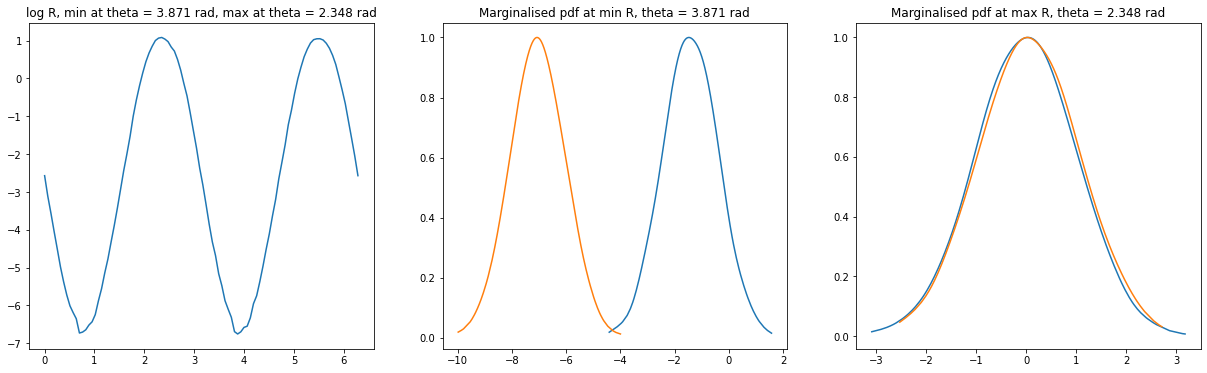

In [8]:
min_theta = thetas[np.argmin(R)]
max_theta = thetas[np.argmax(R)]

fig, axs = plt.subplots(1, 3, figsize=(21, 6))
axs[0].plot(thetas, np.log(R))
axs[0].set_title(f"log R, min at theta = {round(min_theta, 3)} rad, max at theta = {round(max_theta, 3)} rad")

min_n = np.array([np.cos(min_theta), np.sin(min_theta)])
X0_min = dot_n(min_n, X0)
X1_min = dot_n(min_n, X1)
kde_plot_1d(axs[1], X0_min)
kde_plot_1d(axs[1], X1_min)
axs[1].set_title(f"Marginalised pdf at min R, theta = {round(min_theta, 3)} rad")

max_n = np.array([np.cos(max_theta), np.sin(max_theta)])
X0_max = dot_n(max_n, X0)
X1_max = dot_n(max_n, X1)
kde_plot_1d(axs[2], X0_max)
kde_plot_1d(axs[2], X1_max)
axs[2].set_title(f"Marginalised pdf at max R, theta = {round(max_theta, 3)} rad")



### Suspiciousness Statistic S

We use the expression given in the latest draft of the ACT/SPT paper, which involves the average of log likelihoods

In [9]:
def likelihood_function(X, mean=np.array([6/np.sqrt(2)]), cov_mat=np.array([2])):
    if X.shape[1] != mean.shape[0] or mean.shape[0] != cov_mat.shape[0]:
        raise ValueError("dimensions do not match up.")
    else:
        likelihoods = multivariate_normal.pdf(X, mean, cov_mat)
    
    return likelihoods

def marginalised_suspiciousness(n, XA, XB):
    XA_1d = dot_n(n, XA)
    XB_1d = dot_n(n, XB)
    XAB_1d = np.concatenate((XA_1d, XB_1d), axis=0)

    kdeA_1d = gaussian_kde(XA_1d)
    kdeB_1d = gaussian_kde(XB_1d)
    kdeAB_1d = gaussian_kde(XAB_1d)

    kdeA_limits = get_limits(np.reshape(XA_1d, (-1, 1)))
    kdeB_limits = get_limits(np.reshape(XB_1d, (-1, 1)))
    kdeAB_limits = get_limits(np.reshape(XAB_1d, (-1, 1)))

    binsA, weightsA = bin_1d_kde(kdeA_1d, kdeA_limits[0])
    binsB, weightsB = bin_1d_kde(kdeB_1d, kdeB_limits[0])
    binsAB, weightsAB = bin_1d_kde(kdeAB_1d, kdeAB_limits[0])

    # let likelihood function have mean of 6/sqrt(2) and covariance of 2
    avg_llhd_A = sum([np.log(likelihood_function(np.array([[binsA[i]]]))) * weightsA[i] for i in range(len(weightsA))])
    avg_llhd_B = sum([np.log(likelihood_function(np.array([[binsB[i]]]))) * weightsB[i] for i in range(len(weightsB))])
    avg_llhd_AB = sum([np.log(likelihood_function(np.array([[binsAB[i]]]))) * weightsAB[i] for i in range(len(weightsAB))])

    log_S = avg_llhd_AB - avg_llhd_A - avg_llhd_B
    return log_S

In [10]:
thetas = np.linspace(0, 2 * np.pi, 100)
def norm_n(theta):
    return [np.cos(theta), np.sin(theta)]

log_S = np.array([marginalised_bayes_factor(np.array(norm_n(theta)), X0, X1, X_prior) for theta in thetas])

Text(0.5, 1.0, 'Marginalised pdf at max log S, theta = 2.348 rad')

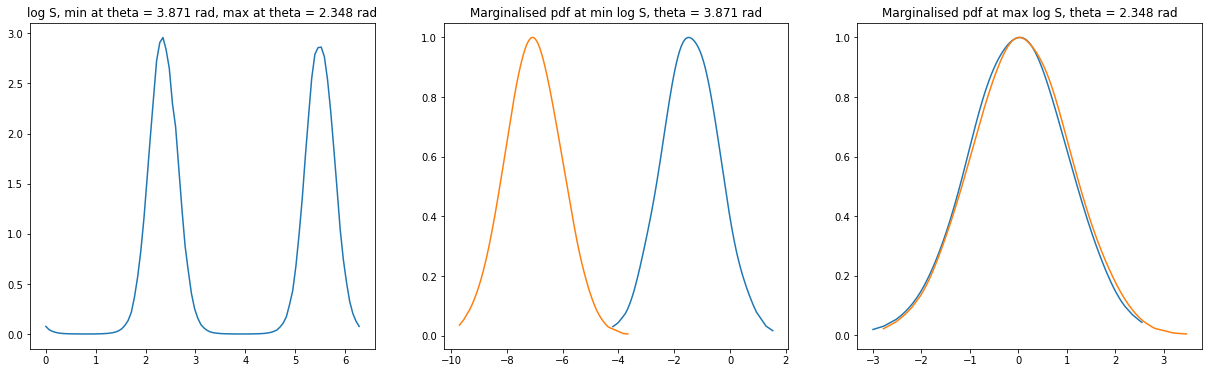

In [11]:
min_theta = thetas[np.argmin(log_S)]
max_theta = thetas[np.argmax(log_S)]

fig, axs = plt.subplots(1, 3, figsize=(21, 6))
axs[0].plot(thetas, log_S)
axs[0].set_title(f"log S, min at theta = {round(min_theta, 3)} rad, max at theta = {round(max_theta, 3)} rad")

min_n = np.array([np.cos(min_theta), np.sin(min_theta)])
X0_min = dot_n(min_n, X0)
X1_min = dot_n(min_n, X1)
kde_plot_1d(axs[1], X0_min)
kde_plot_1d(axs[1], X1_min)
axs[1].set_title(f"Marginalised pdf at min log S, theta = {round(min_theta, 3)} rad")

max_n = np.array([np.cos(max_theta), np.sin(max_theta)])
X0_max = dot_n(max_n, X0)
X1_max = dot_n(max_n, X1)
kde_plot_1d(axs[2], X0_max)
kde_plot_1d(axs[2], X1_max)
axs[2].set_title(f"Marginalised pdf at max log S, theta = {round(max_theta, 3)} rad")

## Let's plot T(theta) at maximal tension
In this case, this would be n \propto (1, 1)


In [53]:
max_n = np.array([1/np.sqrt(2), 1/np.sqrt(2)])

x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
grid_x, grid_y = np.meshgrid(x, y)
xy = np.concatenate((np.reshape(grid_x, (1, -1)), np.reshape(grid_y, (1, -1))), axis=0)
xy = np.transpose(xy)
z = np.matmul(xy, max_n)
grid_z = np.reshape(z, grid_x.shape)

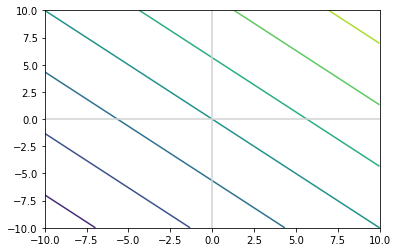

In [55]:
plt.contour(grid_x, grid_y, grid_z)
plt.axvline(0, color='lightgrey')
plt.axhline(0, color='lightgrey')